# Amplitude embedding (simulator)

Main steps:

* initialize an image of the sky (frequency domain)
* apply 2D FT --> visibilities (Fourier domain)
* encode visibilities data into qubits using amplitude embedding (non-conventional domain)
* measure qubits on simulator --> expected outcomes (back to conventional domain)
* apply 2D IFT --> fidelity computation

Basis embedding:

* from https://docs.pennylane.ai/en/stable/code/api/pennylane.AmplitudeEmbedding.html
* literature: https://hillside.net/plop/2020/papers/weigold.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import pennylane as qml
from pennylane import numpy as pnp

### Prerequisites

In [2]:
# create a circular mask over a 2D array
def circular_mask(h, w, center=None, radius=None):
    if center is None: # image center
        center = (int(w/2), int(h/2))
    if radius is None: # smallest distance between center and image bounderies
        radius = min(center[0], center[1], w-center[0], h-center[1])
        
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    
    return mask

## 1) Generating an artificial image of the sky (frequency domain)

In [3]:
# image of the sky filled with double precision complex floats (32 bits per real/imaginary parts)
# pixels are set to low complex random values (image background/noise) 
# few pixels are set to larger complex random values in a specified ellipse area (image source/subject)

n = 4
image = np.zeros((n, n), dtype='complex64')
image.real = np.random.randn(n , n)/10
image.imag = np.random.randn(n , n)/100

h, w = image.shape
mask = circular_mask(h, w, radius=h/3)
sky_image = image.copy()
sky_image[mask] = complex(np.random.rand()*10, np.random.rand()*10)
print(sky_image)

[[ 0.0905954 -1.2271356e-02j  0.05291409-1.6985876e-02j
  -0.09753196+4.6703001e-03j  0.07869019+2.4044598e-03j]
 [ 0.01800756-3.1059102e-05j  0.00952214+3.6091493e-03j
   2.6820474 +2.8667905e+00j  0.02046308+1.2379115e-02j]
 [ 0.015766  +4.1269800e-03j  2.6820474 +2.8667905e+00j
   2.6820474 +2.8667905e+00j  2.6820474 +2.8667905e+00j]
 [ 0.01531104-1.2062793e-02j  0.17695148-7.8023826e-03j
   2.6820474 +2.8667905e+00j  0.04057962-1.7405070e-02j]]


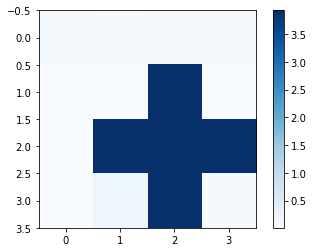

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying a 2D FT (Fourier domain)

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[13.831506 +14.294584j  -7.827488  -8.724935j   2.345075  +2.8750231j
  -7.7903724 -8.525625j ]
 [-7.8840127 -8.441832j   2.9943628 +2.8871741j  2.4985766 +2.6794014j
   2.738518  +2.7988765j]
 [ 2.5416462 +2.870048j   2.8323991 +3.0172768j -7.954719  -8.58639j
   2.8728452 +2.7148626j]
 [-7.990468  -8.81153j    2.675674  +2.8558218j  2.5569046 +3.0598862j
   3.0090802 +2.8410149j]]


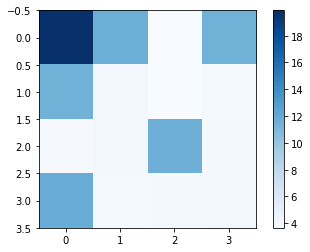

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

### Sanity check

In [7]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()
 
print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 7.5211105e-16
Imaginaries MSE: 1.0039389e-15


## 3) Data encoding: amplitude embedding (non-conventional domain)

In [8]:
# Amplitude embedding encodes a normalized 2^n-dimensional feature vector into the state of n qubits
# --> uses log2(n) qubits for n classical data

n = visibilities.shape[0]*visibilities.shape[1]
data = visibilities.flatten()

#normalization to prepare a qstate with measurement probabilites summing up to 1 (SUM (amplitudes²) = 1)
norm = qml.math.sum(qml.math.abs(data) ** 2)
normalized_data = data / qml.math.sqrt(norm)

wires = range(int(math.log2(n))) # set the number of qubits (no padding needed if outputs an integer=integer.0)
amp_dev = qml.device('default.qubit', wires)

# encoding
@qml.qnode(amp_dev)
def amp_encoding(data):
    qml.AmplitudeEmbedding(data, wires) # normalize = True
    return qml.state() #qml.expval(qml.PauliZ(wires=wires))

readout = amp_encoding(normalized_data).astype('complex64')
readout = readout*qml.math.sqrt(norm) # denormalization of the measurements outcomes
readout = np.array(readout).reshape(sky_image.shape[0] , sky_image.shape[1])
print(readout)

[[13.831507 +14.294584j  -7.827488  -8.724935j   2.345075  +2.8750231j
  -7.7903724 -8.525625j ]
 [-7.8840127 -8.441832j   2.9943628 +2.8871741j  2.4985766 +2.6794014j
   2.738518  +2.7988765j]
 [ 2.5416462 +2.870048j   2.8323991 +3.017277j  -7.954719  -8.58639j
   2.8728452 +2.7148626j]
 [-7.990468  -8.81153j    2.675674  +2.8558218j  2.5569046 +3.0598862j
   3.0090802 +2.8410149j]]


## 4) Applying 2D IFT (fidelity test)

In [9]:
img = np.fft.ifft2(readout).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 4.9067738e-15
Imaginaries MSE: 1.0369732e-15
